Making colour-colour diagrams and applying machine learning tecniques

In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import pandas as pd
from astropy.table import Table, vstack
import hdbscan
from pathlib import Path
import seaborn as sns
import glob
import json
%matplotlib inline
sns.set_color_codes()

In [2]:
ROOT_PATH = Path("..") 

In [3]:
table = Table.read("Final-list-emitters-allparam-unique.ecsv", format="ascii.ecsv")

In [4]:

len(table)

8446

In [5]:
table.colnames

['Field',
 'ID',
 'RA',
 'DEC',
 'FWHM',
 'ISOarea',
 'KRON_RADIUS',
 'MU_MAX',
 'nDet_PStotal',
 'PhotoFlagDet',
 'u_PStotal',
 'J0378_PStotal',
 'J0395_PStotal',
 'J0410_PStotal',
 'J0430_PStotal',
 'g_PStotal',
 'J0515_PStotal',
 'r_PStotal',
 'J0660_PStotal',
 'i_PStotal',
 'J0861_PStotal',
 'z_PStotal',
 'e_u_PStotal',
 'e_J0378_PStotal',
 'e_J0395_PStotal',
 'e_J0410_PStotal',
 'e_J0430_PStotal',
 'e_g_PStotal',
 'e_J0515_PStotal',
 'e_r_PStotal',
 'e_J0660_PStotal',
 'e_i_PStotal',
 'e_J0861_PStotal',
 'e_z_PStotal']

In [6]:
# Colors
m = (table["e_g_PStotal"] <= 0.2) & (table["e_i_PStotal"] <= 0.2) & (table["e_z_PStotal"] <= 0.2)
m1 =  (table["e_u_PStotal"] <= 0.2) &(table["e_g_PStotal"] <= 0.2) & (table["e_i_PStotal"] <= 0.2) 
zg = table['z_PStotal'][m] - table['g_PStotal'][m]
gr = table['g_PStotal'][m] - table['r_PStotal'][m]
ri = table['r_PStotal'][m] - table['i_PStotal'][m]
ug = table['u_PStotal'][m1] - table['g_PStotal'][m1]
gr_ = table['g_PStotal'][m1] - table['r_PStotal'][m1]
rz = table['r_PStotal'][m] - table['z_PStotal'][m]

/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


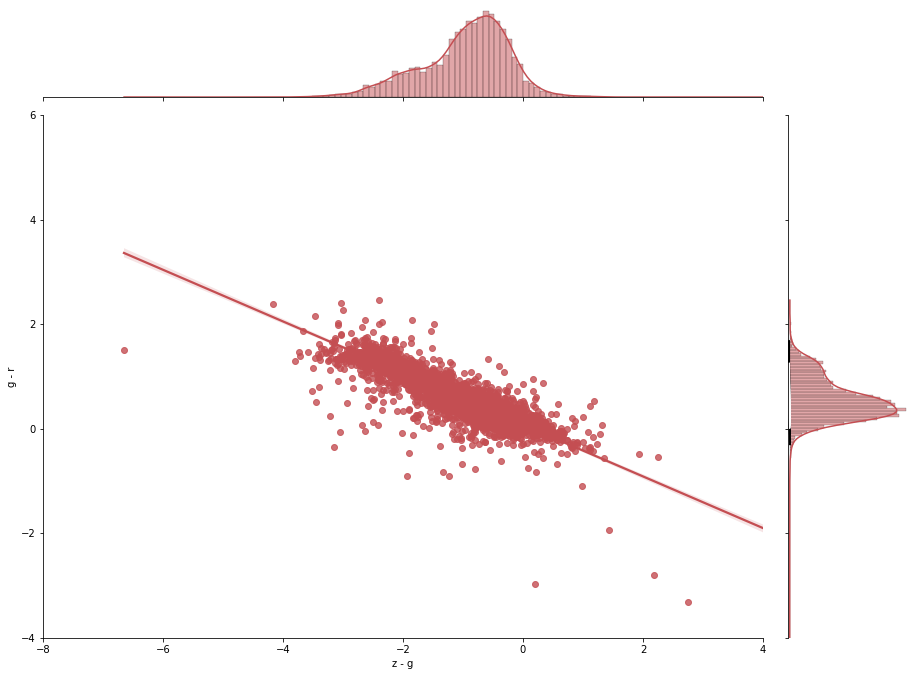

In [7]:
ax = sns.jointplot(zg, gr, kind="reg", color="r")
ax.ax_joint.set(xlim=[-8, 4], ylim=[-4, 6],
               xlabel=r"z - g",
    ylabel=r"g - r")
pal = sns.cubehelix_palette(start=1, rot=0, dark=-10, light=50, reverse=True, as_cmap=True)
sns.kdeplot(
    zg, gr,
    cmap=pal,
)
# Limiting the blue and red region
x_new = np.linspace(-15.0, 1000, 200)
y = 0.35*x_new + 1.5

#ax.ax_joint.set_aspect("equal")
ax.fig.set_size_inches(14, 10)

/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


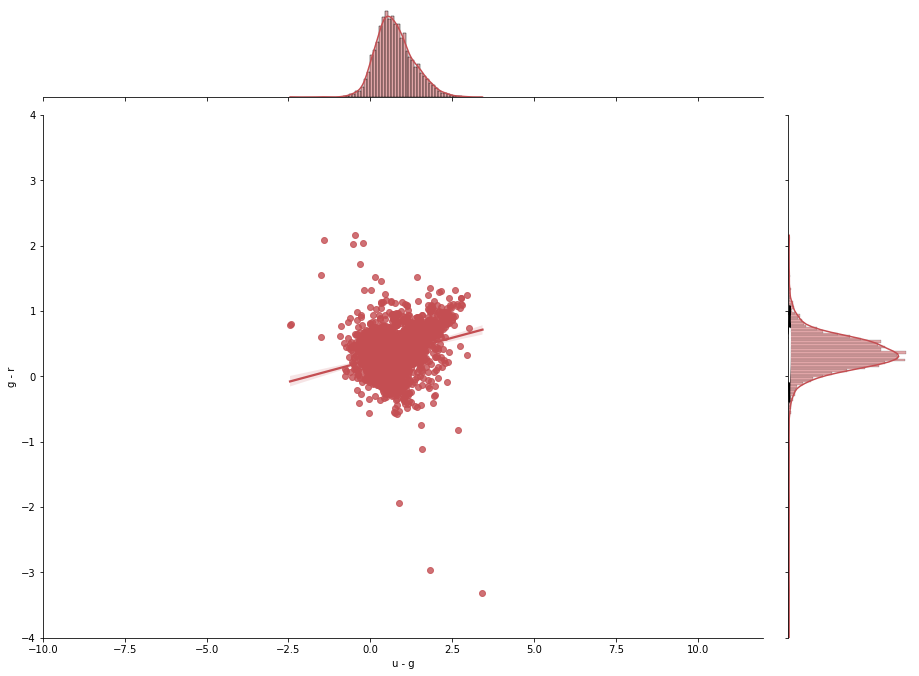

In [8]:
ax = sns.jointplot(ug, gr_, kind="reg", color="r")
ax.ax_joint.set(xlim=[-10, 12], ylim=[-4, 4],
               xlabel=r"u - g",
    ylabel=r"g - r")
pal = sns.cubehelix_palette(start=1, rot=0, dark=-10, light=50, reverse=True, as_cmap=True)
sns.kdeplot(
    ug, gr_,
    cmap=pal,
)
#ax.ax_joint.set_aspect("equal")
ax.fig.set_size_inches(14, 10)

/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


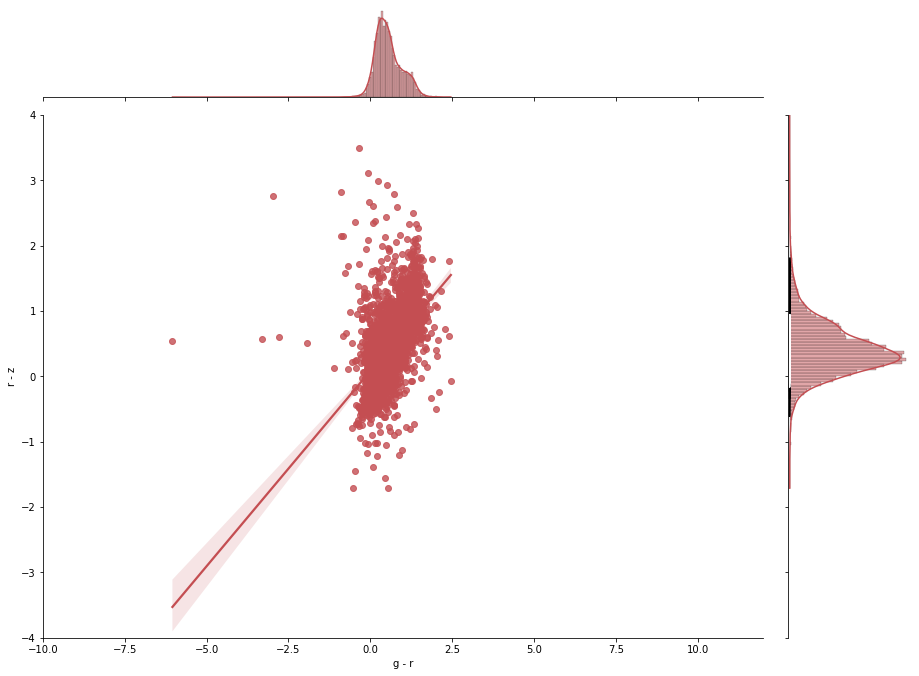

In [9]:
ax = sns.jointplot(gr, rz, kind="reg", color="r")
ax.ax_joint.set(xlim=[-10, 12], ylim=[-4, 4],
               xlabel=r"g - r",
    ylabel=r"r - z")
pal = sns.cubehelix_palette(start=1, rot=0, dark=-10, light=50, reverse=True, as_cmap=True)
sns.kdeplot(
    gr, rz,
    cmap=pal,
)
#ax.ax_joint.set_aspect("equal")
ax.fig.set_size_inches(14, 10)

# Using pomegranate

In [10]:
from pomegranate import GeneralMixtureModel, MultivariateGaussianDistribution

In [11]:
X = np.array(list(zip(gr, rz)))
X.shape
# Standarized the data
X = StandardScaler().fit_transform(X)

In [12]:
rel_err = np.hypot(
    rz,
    gr,
)
weights = 1.0 / rel_err ** 2
weights[rel_err == 0.0] = np.nanmedian(weights)
max_weight = 4.0 * np.nanmedian(weights)
weights[weights > max_weight] = max_weight
weights[::10]


9.638367
2.2002983
2.6041014
1.2520596
2.544331
6.851531
2.6576056
1.6179897
2.6146834
2.5293186
...


In [13]:
N_COMPONENTS = 2

In [14]:
model = GeneralMixtureModel.from_samples(
    distributions=MultivariateGaussianDistribution,
    n_components=N_COMPONENTS,
    X=X,
    weights=weights,
)


In [15]:
plabels = model.predict(X)
plabels

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [16]:
xmin, xmax = 0.75, 15
ymin, ymax = 0.75, 15
NP = 1000
xx, yy = np.meshgrid(np.linspace(xmin, xmax, NP), np.linspace(ymin, ymax, NP),)
x_ = np.array(list(zip(xx.flatten(), yy.flatten())))
p_components = model.predict_proba(np.log10(x_)).reshape((NP, NP, N_COMPONENTS))
p_tot = model.probability(np.log10(x_)).reshape((NP, NP))
p_tot /= p_tot.max()

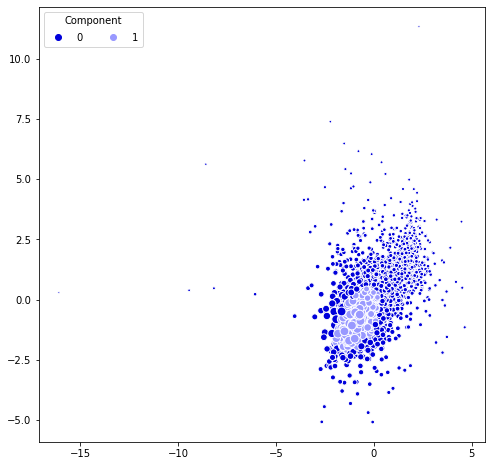

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
#   for k in range(1, N_COMPONENTS):
#    ax.contour(xx, yy, p_components[:, :, k], levels=[0.5], cmap="Reds_r", zorder=-2)
levels = np.array([0.001, 0.003, 0.01, 0.03, 0.1, 1.0])
GAMMA = 0.05
#ax.contourf(
    #xx, yy, p_tot ** GAMMA, levels=levels ** GAMMA, cmap="Greens", zorder=-1, alpha=0.5
#)
scatter = ax.scatter(
    X[:, 0],
    X[:, 1],
    c=plabels,
    s=25 * np.sqrt(weights),
    edgecolors="w",
    linewidths=1,
    vmin=-1,
    vmax=4,
    cmap="seismic",
)
ax.set(
    #xscale="log",
    #yscale="log",
    #xlim=[xmin, xmax],
    #ylim=[ymin, ymax],
    #xlabel=r"Planitude, $\Pi$",
    #ylabel=r"Alatude, $\Lambda$",
)
ax.legend(*scatter.legend_elements(), ncol=2, title="Component")
#ax.set_aspect("equal")

# Fitting a Gaussian Mixture Model with Scikit-learn’s GaussianMixture() function 

In [18]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler


In [19]:
# Standarized the data
#X = StandardScaler().fit_transform(X)

In [20]:
gmm = GaussianMixture(2, 
                     covariance_type='full', 
                     random_state=0).fit(X)

In [21]:
gmm.means_

array([[ 0.25131947,  0.62165574],
       [-0.05919909, -0.14643295]])

In [22]:
labels = gmm.predict(X)

/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='r_PStotal', ylabel='g_PStotal'>

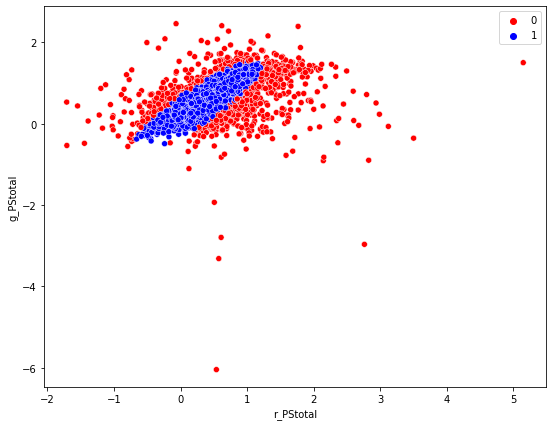

In [23]:
plt.figure(figsize=(9,7))
sns.scatterplot(rz, gr, 
                hue=labels,
                palette=["red","blue"])
#plt.savefig("fitting_Gaussian_Mixture_Models_with_3_components_scikit_learn_Python.png",
                    #format='png',dpi=150)

# Using k-nearst

In [24]:
from sklearn.cluster import KMeans

In [25]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

KMeans(n_clusters=2)

In [26]:
#predictions from kmeans
label = kmeans.labels_
pred = kmeans.predict(X)
print(label, pred)

[0 0 0 ... 1 1 0] [0 0 0 ... 1 1 0]


No handles with labels found to put in legend.


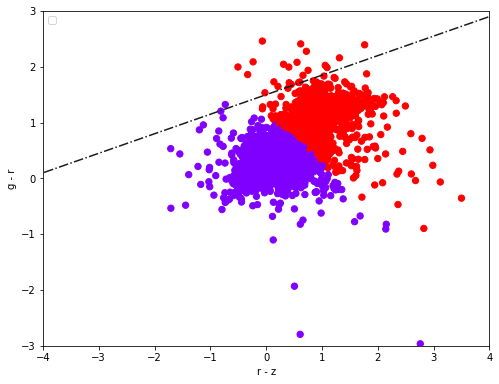

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set(
        xlim=[-4, 4], ylim=[-3., 3.]
      )
ax.scatter(rz, gr, c=label, s=40, cmap="rainbow")
ax.set(
    #xscale="log",
    #yscale="log",
    #xlim=[0.75, 15],
    #ylim=[0.75, 15],
    xlabel=r"r - z",
    ylabel=r"g - r",
)
# Limiting the blue and red region
x_new = np.linspace(-15.0, 1000, 200)
y = 0.35*x_new + 1.5
ax.plot(x_new, y, color='k', zorder=100, linestyle='-.')
ax.legend()
ax.set_aspect("equal")

/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='r_PStotal', ylabel='g_PStotal'>

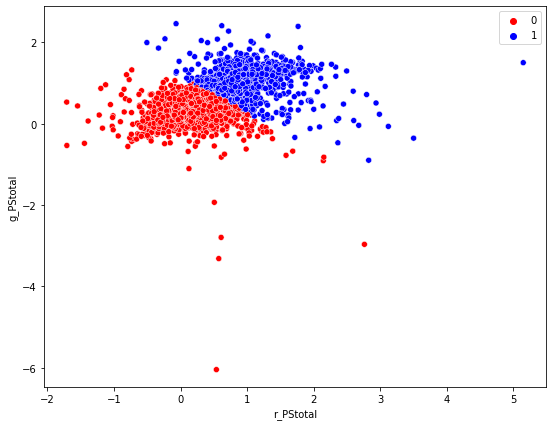

In [28]:
plt.figure(figsize=(9,7))
sns.scatterplot(rz, gr, 
                hue=label,
                palette=["red","blue"])

In [29]:
table_= table[m]
table_["Label_k"] = label
mask0 = table_["Label_k"] == 0
mask1 = table_["Label_k"] == 1

In [30]:
# Iphaas colors
ri_0 = table_['r_PStotal'][mask0] - table_['i_PStotal'][mask0]
rj660_0 = table_['r_PStotal'][mask0] - table_['J0660_PStotal'][mask0]
ri_1 = table_['r_PStotal'][mask1] - table_['i_PStotal'][mask1]
rj660_1 = table_['r_PStotal'][mask1] - table_['J0660_PStotal'][mask1]
len(ri_0)

4979

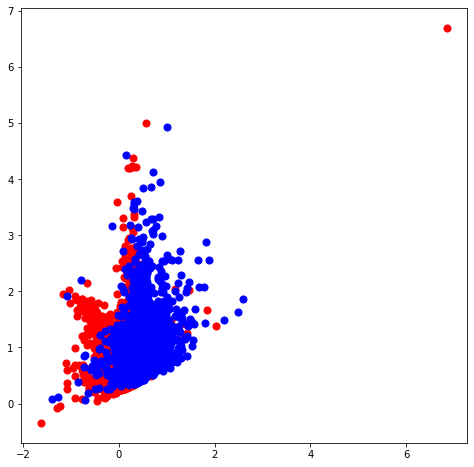

In [31]:
fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.scatter(ri_0, rj660_0, c="red",
            s=50, cmap='viridis');
ax1.scatter(ri_1, rj660_1, c="blue",
            s=50, cmap='viridis');

In [32]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(label)) - (1 if -1 in label else 0)
n_cluster0 = list(label).count(0)
n_cluster1 = list(label).count(1)
# Print parameters
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of cluster points 0: %d' % n_cluster0)
print('Estimated number of cluster points 1: %d' % n_cluster1)


Estimated number of clusters: 2
Estimated number of cluster points 0: 4979
Estimated number of cluster points 1: 2107


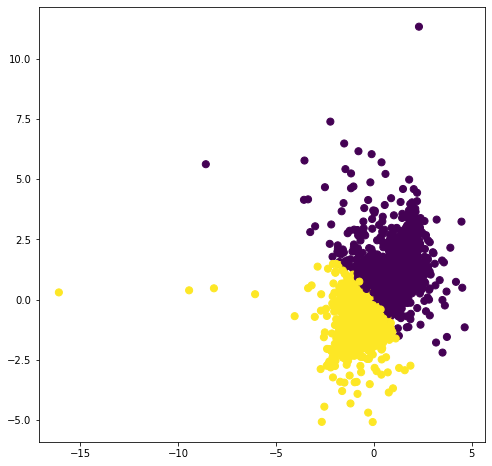

In [33]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='r_PStotal', ylabel='g_PStotal'>

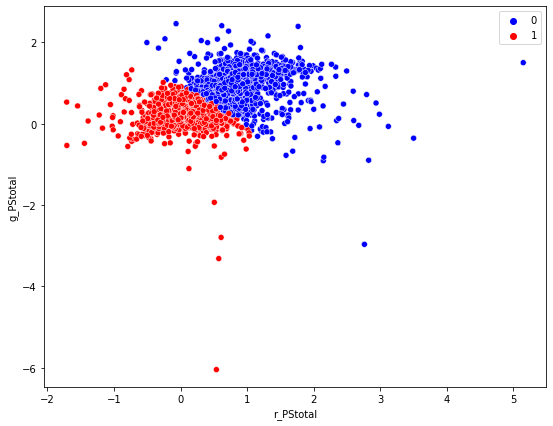

In [34]:
plt.figure(figsize=(9,7))
sns.scatterplot(rz, gr, 
                hue=labels,
                palette=["blue","red"])

In [35]:
table_["Label_sp"] = labels
masks0 = table_["Label_sp"] == 0
masks1 = table_["Label_sp"] == 1
# Iphaas colors
ris_0 = table_['r_PStotal'][masks0] - table_['i_PStotal'][masks0]
rj660s_0 = table_['r_PStotal'][masks0] - table_['J0660_PStotal'][masks0]
ris_1 = table_['r_PStotal'][masks1] - table_['i_PStotal'][masks1]
rj660s_1 = table_['r_PStotal'][masks1] - table_['J0660_PStotal'][masks1]
len(ris_0)

3032

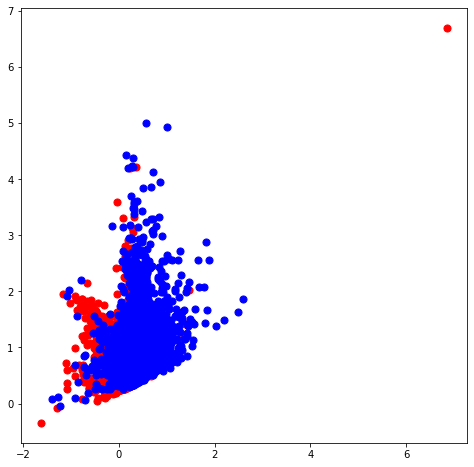

In [36]:
fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.scatter(ris_0, rj660s_0, c="blue",
            s=50, cmap='viridis',  zorder=3);
ax1.scatter(ris_1, rj660s_1, c="red",
            s=50, cmap='viridis', zorder=2);

In [37]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_cluster0 = list(labels).count(0)
n_cluster1 = list(labels).count(1)
# Print parameters
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of cluster points 0: %d' % n_cluster0)
print('Estimated number of cluster points 1: %d' % n_cluster1)


Estimated number of clusters: 2
Estimated number of cluster points 0: 3032
Estimated number of cluster points 1: 4054


# Using HDBSCAN

In [38]:
import hdbscan

In [39]:
# Applying HDBSCAN
clusterer = hdbscan.HDBSCAN(min_samples=20, min_cluster_size=80, prediction_data=True).fit(X)
labels_h = clusterer.labels_

In [40]:
clusterer.metric

'euclidean'

In [41]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_h)) - (1 if -1 in labels_h else 0)
n_cluster0 = list(labels_h).count(0)
n_cluster1 = list(labels_h).count(1)
n_cluster2 = list(labels_h).count(2)
n_noise_ = list(labels_h).count(-1)

In [42]:
# Print parameters
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of cluster points 0: %d' % n_cluster0)
print('Estimated number of cluster points 1: %d' % n_cluster1)
print('Estimated number of cluster points 2: %d' % n_cluster2)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 2
Estimated number of cluster points 0: 221
Estimated number of cluster points 1: 3812
Estimated number of cluster points 2: 0
Estimated number of noise points: 3053


/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='g_PStotal', ylabel='r_PStotal'>

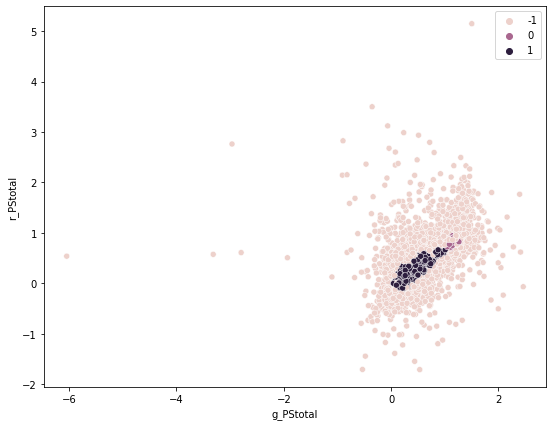

In [80]:
plt.figure(figsize=(9,7))
sns.scatterplot(gr, rz, 
                hue=labels_h,
                )

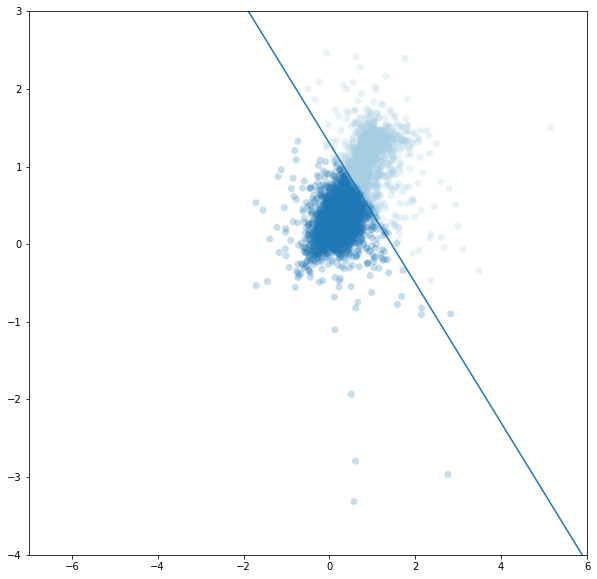

In [91]:
soft_clusters0 = hdbscan.all_points_membership_vectors(clusterer)
color_palette0 = sns.color_palette('Paired', 12)
cluster_colors0 = [color_palette0[np.argmax(x)]
                  for x in soft_clusters0]
y = -0.9*x_new + 1.3
plt.figure(figsize=(10,10))
plt.scatter(rz, gr, s=50, linewidth=0, c=cluster_colors0, alpha=0.25)
plt.xlim([-7, 6])
plt.ylim([-4, 3])
plt.plot(x_new, y)

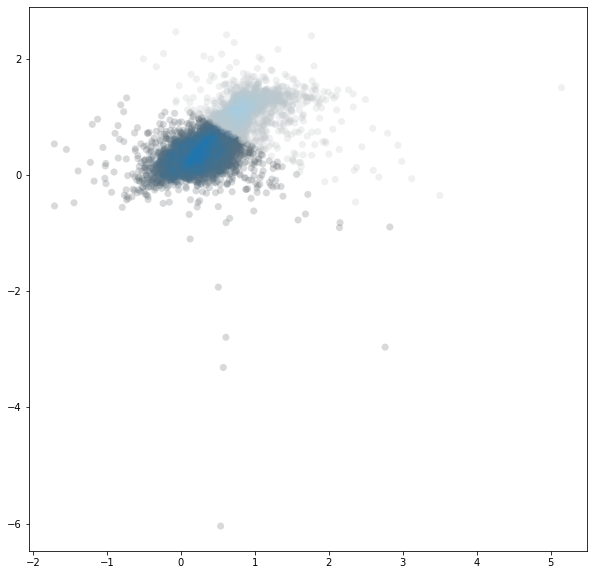

In [45]:
color_palette1 = sns.color_palette('Paired', 12)
cluster_colors1 = [sns.desaturate(color_palette1[np.argmax(x)], np.max(x))
                  for x in soft_clusters0]
plt.figure(figsize=(10,10))
plt.scatter(rz, gr, s=50, linewidth=0, c=cluster_colors1, alpha=0.25)

# Hierarchical Clustering

Role of Dendrograms for Hierarchical Clustering

In [46]:
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc

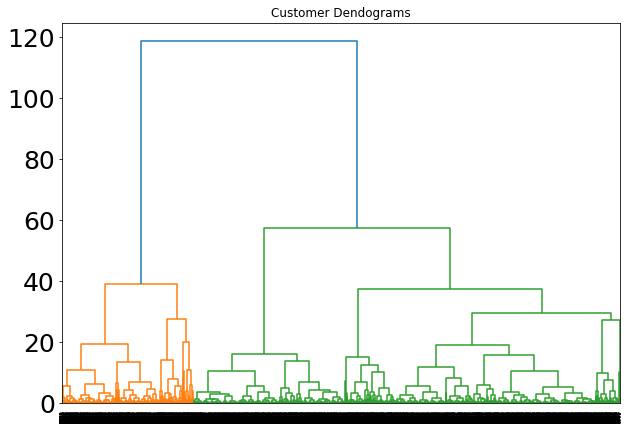

In [47]:
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
plt.tick_params(axis='y', labelsize=25)
dend = shc.dendrogram(shc.linkage(X, method='ward'))

In [48]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
model.fit_predict(X)

array([0, 0, 0, ..., 1, 1, 1])

In [49]:
label_hi=model.labels_

/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


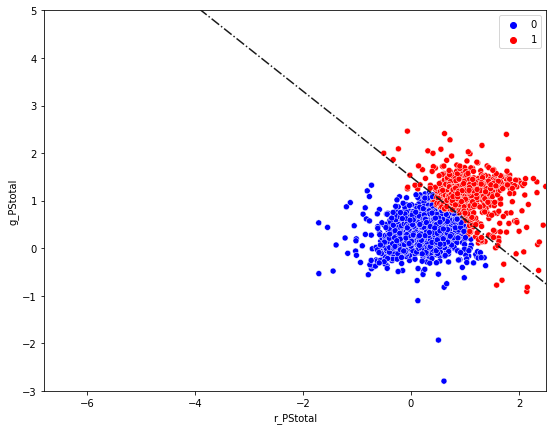

In [93]:
plt.figure(figsize=(9,7))
plt.axis([-6.8, 2.5, -3., 5.])
sns.scatterplot(rz, gr, 
                hue=label_hi,
                palette=["blue","red"])

# Limiting the blue and red region
x_new = np.linspace(-15.0, 1000, 200)
y = -0.9*x_new + 1.5

plt.plot(x_new, y, color='k', zorder=100, linestyle='-.')

In [51]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(label_hi)) - (1 if -1 in label_hi else 0)
n_cluster0 = list(label_hi).count(0)
n_cluster1 = list(label_hi).count(1)
# Print parameters
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of cluster points 0: %d' % n_cluster0)
print('Estimated number of cluster points 1: %d' % n_cluster1)


Estimated number of clusters: 2
Estimated number of cluster points 0: 5411
Estimated number of cluster points 1: 1675


In [52]:
table_["Label_hier"] = label_hi
mask_h0 = table_["Label_hier"] == 0
mask_h1 = table_["Label_hier"] == 1
# Iphaas colors
ri_h0 = table_['r_PStotal'][mask_h0] - table_['i_PStotal'][mask_h0]
rj660_h0 = table_['r_PStotal'][mask_h0] - table_['J0660_PStotal'][mask_h0]
ri_h1 = table_['r_PStotal'][mask_h1] - table_['i_PStotal'][mask_h1]
rj660_h1 = table_['r_PStotal'][mask_h1] - table_['J0660_PStotal'][mask_h1]

In [53]:
# save the files blue and red ones
asciifile0 = "Blue0-Good-LD-Halpha-DR3_noFlag_merge-takeoutbad-Final-newColors.ecsv" 
asciifile1 = "Red1-Good-LD-Halpha-DR3_noFlag_merge-takeoutbad-Final-newColors.ecsv" 
table_[mask_h0].write(asciifile0, format="ascii.ecsv")
table_[mask_h1].write(asciifile1, format="ascii.ecsv")

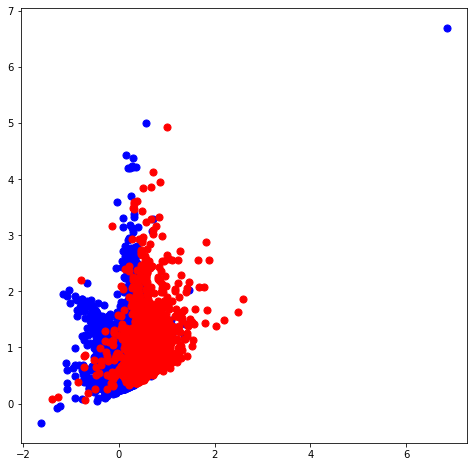

In [54]:
fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.scatter(ri_h0, rj660_h0, c="blue",
            s=50, cmap='viridis');
ax1.scatter(ri_h1, rj660_h1, c="red",
            s=50, cmap='viridis');

# OPTICS

In [55]:
from sklearn.cluster import OPTICS


In [56]:
clustering = OPTICS(min_samples=30).fit(X)
clustering.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [57]:
label_op = clustering.labels_

/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='r_PStotal', ylabel='g_PStotal'>

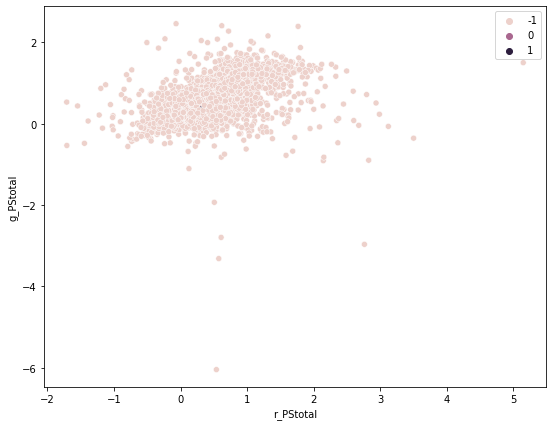

In [58]:
plt.figure(figsize=(9,7))
sns.scatterplot(rz, gr, 
                hue=label_op,
                )

In [59]:
from sklearn.cluster import DBSCAN

In [60]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labelss = db.labels_


In [61]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labelss)) - (1 if -1 in labelss else 0)
n_noise_ = list(labelss).count(-1)

In [62]:
print(n_clusters_)

1


/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='r_PStotal', ylabel='g_PStotal'>

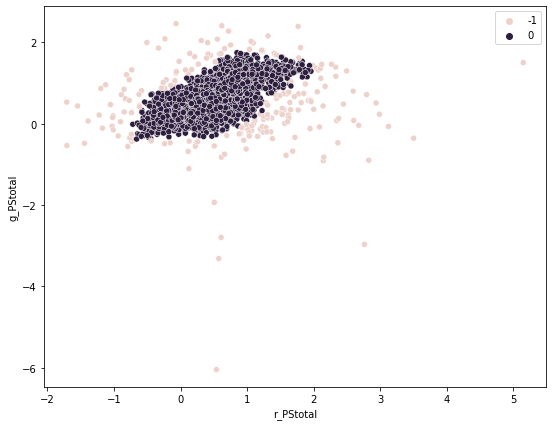

In [63]:
plt.figure(figsize=(9,7))
sns.scatterplot(rz, gr, 
                hue=labelss,
                )

# Principal component analisis

In [64]:
from sklearn.decomposition import PCA

In [65]:
X_new = np.array(list(zip(zg, gr)))
print(X_new.shape)
# Standarized the data
X_new = StandardScaler().fit_transform(X_new)

(7086, 2)


In [66]:
# Creating the PCA 
pca = PCA(n_components=2)
pca.fit(X_new)

X_pca = pca.transform(X_new)

In [67]:
#porcentages
print("Porcentage:", pca.explained_variance_ratio_)
print("Singular Value:", pca.singular_values_)
print("Component:", pca.components_) # eigevectors
print("Sorted components:", pca.explained_variance_) # eigenvalues

Porcentage: [0.9442922  0.05570779]
Singular Value: [115.6828    28.097881]
Component: [[ 0.7071067 -0.7071068]
 [-0.7071068 -0.7071067]]
Sorted components: [1.8888512  0.11143132]


[(-7.0, 8.0), (-10.0, 10.0)]

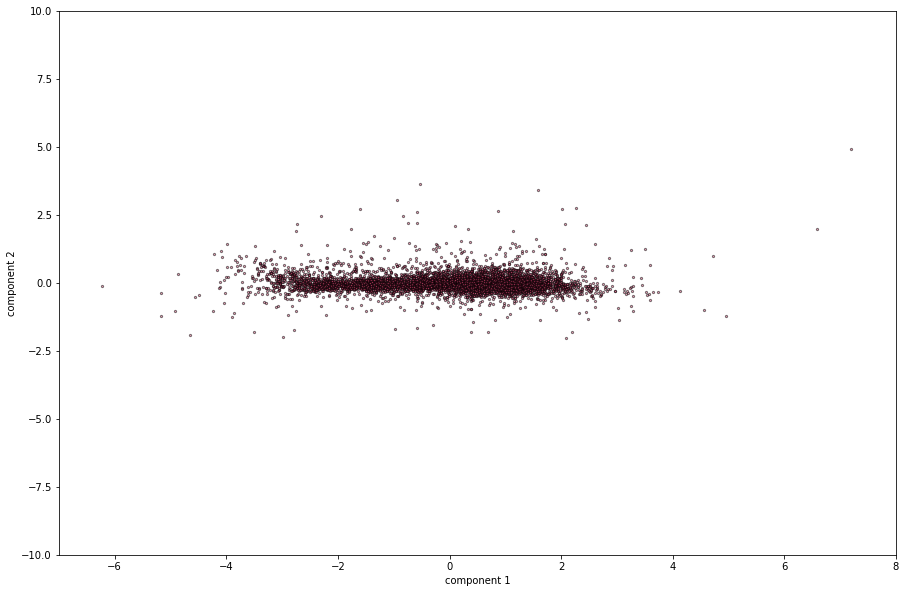

In [68]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(X_pca[:, 0], X_pca[:, 1],
            c=sns.xkcd_rgb['dark pink'], s=5, edgecolor='black', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set(xlim=[-7.0, 8.0], ylim=[-10.0, 10.0])

[(-7.0, 8.0), (-10.0, 10.0)]

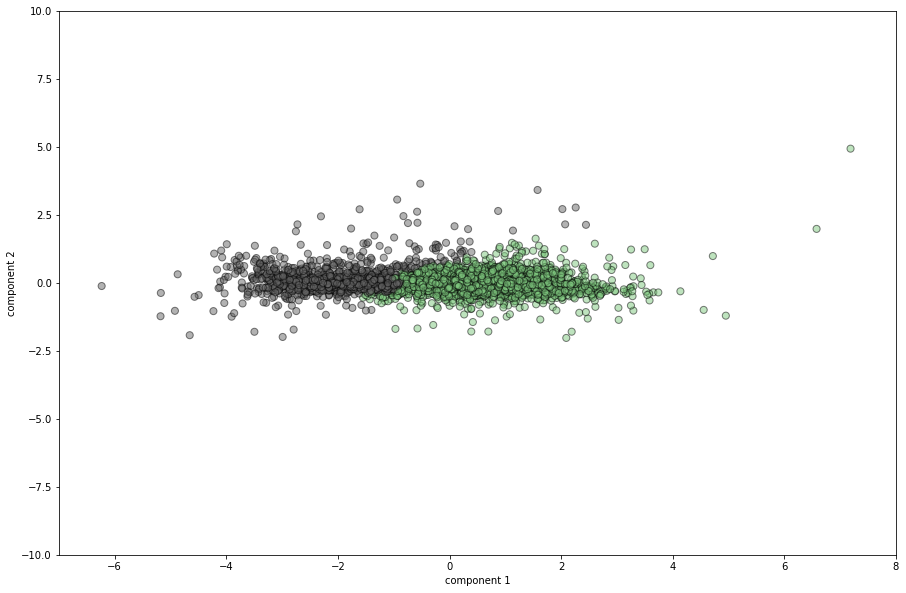

In [69]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(X_pca[:, 0], X_pca[:, 1],
            c=label_hi, s=50, edgecolor='black', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set(xlim=[-7.0, 8.0], ylim=[-10.0, 10.0])

# Again HDBSCAN

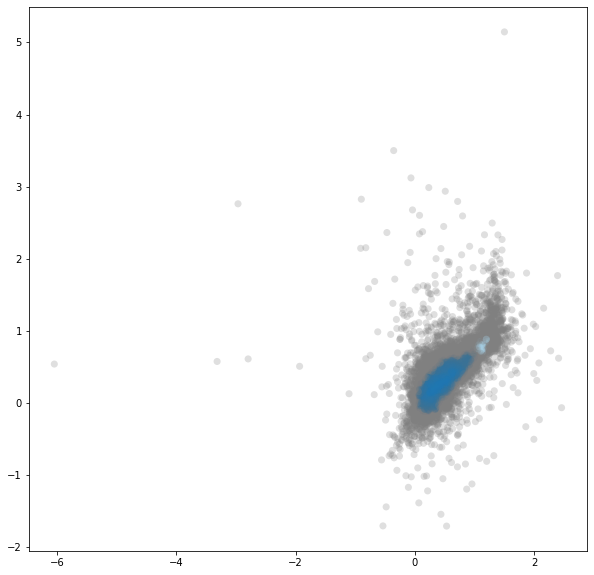

In [94]:
clusterer1 = hdbscan.HDBSCAN(min_cluster_size=100, prediction_data=True).fit(X_new)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer1.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer1.probabilities_)]
plt.figure(figsize=(10,10))
plt.scatter(gr, rz, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

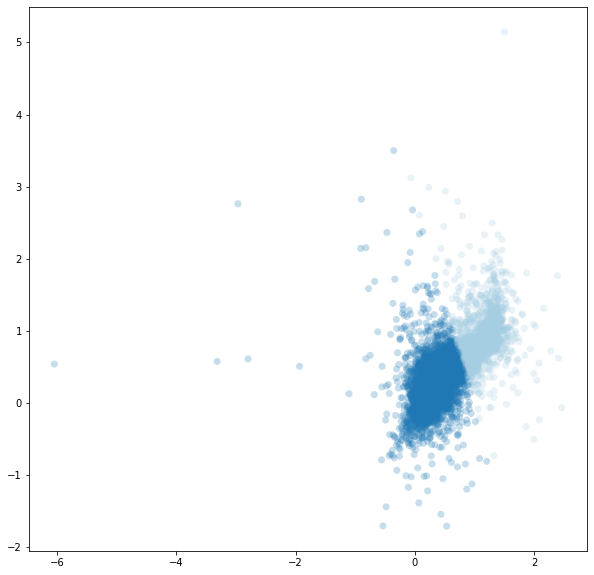

In [95]:
soft_clusters = hdbscan.all_points_membership_vectors(clusterer1)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[np.argmax(x)]
                  for x in soft_clusters]
plt.figure(figsize=(10,10))
plt.scatter(gr, rz, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

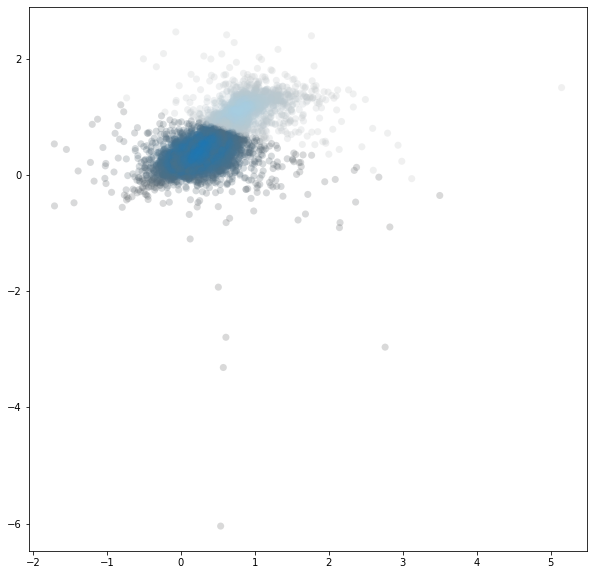

In [72]:
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [sns.desaturate(color_palette[np.argmax(x)], np.max(x))
                  for x in soft_clusters]
plt.figure(figsize=(10,10))
plt.scatter(rz, gr, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

# Using all bands

In [73]:
df_table = table[m].to_pandas()

In [74]:
# Selecting colums
df_clus_temp = df_table[["u_PStotal", "J0378_PStotal", "J0395_PStotal", "J0410_PStotal", "J0430_PStotal", "g_PStotal", "J0515_PStotal", "r_PStotal", "J0660_PStotal", "i_PStotal", "J0861_PStotal", "z_PStotal"]]
df_clus_temp.shape

(7086, 12)

In [75]:
df_clus_temp.values

array([[15.115198, 14.909287, 14.710892, ..., 15.113718, 15.232575,
        15.262193],
       [16.546637, 16.135178, 16.218506, ..., 15.911624, 15.856656,
        15.725164],
       [16.781006, 16.324741, 16.464666, ..., 16.037136, 16.032978,
        15.763049],
       ...,
       [99.      , 21.439228, 22.56422 , ..., 20.05666 , 18.879686,
        19.07044 ],
       [25.002989, 99.      , 99.      , ..., 19.537561, 17.25114 ,
        17.850922],
       [99.      , 22.44407 , 24.301083, ..., 19.69756 , 18.332882,
        18.724873]], dtype=float32)

In [76]:
# Standarized the data
df_clus_temp_stand = StandardScaler().fit_transform(df_clus_temp.values)
df_clus_temp_stand.shape

(7086, 12)

In [77]:
# Creating the PCA 
pca1 = PCA(n_components=2)
pca1.fit(df_clus_temp_stand)

X_pca1 = pca1.transform(df_clus_temp_stand)

[(-7.0, 8.0), (-10.0, 10.0)]

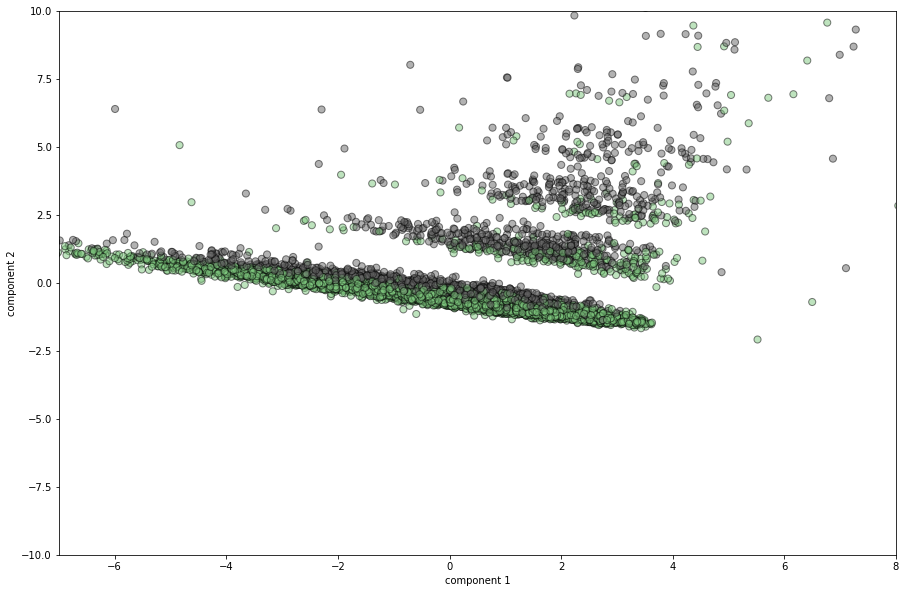

In [78]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(X_pca1[:, 0], X_pca1[:, 1],
            c=label_hi, s=50, edgecolor='black', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set(xlim=[-7.0, 8.0], ylim=[-10.0, 10.0])

# ADBSCAN

A-DSBCAN is an extension of the original DBSCAN algorithm that creates an ensemble of solutions generated by running DBSCAN on a random subset and “extending” the solution to the rest of the sample through nearest-neighbor regression.

See the original reference ([ab_gl_vm2020joue]) for more details or the notebook guide for an illustration. …

https://pysal.org/esda/generated/esda.adbscan.ADBSCAN.html

In [79]:
from esda.adbscan import ADBSCAN

/home/luis/anaconda3/lib/python3.8/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")
